In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Dataset and Settings

In [2]:
MODIFIED_SGD = True
SAVE = True

In [3]:
DATASET = 'cifar10'
if DATASET     == 'cifar10':
    mb_size    = 10         # mini-batch size (default : 10)
    n          = 300        # number of mini-batches in a large batch
    lb_size    = n*mb_size  # large batch size (after this gradient update with modified SGD rule)  
    n_lb       = int(50000.0/(lb_size)) # number of large batches in a epoch
    epochs     = 100
    lr         = 0.1
    momentum   = 0.0    
    mean_imgs  = (0.5,0.5,0.5)
    std_imgs   = (0.5,0.5,0.5)
    imgs_shape = (3,32,32)

In [4]:
import os
ROOT = '/home/ansuini/repos/WellTemperedSGD/'
os.chdir(ROOT)

In [5]:
if MODIFIED_SGD:
    RES = os.path.join(ROOT,'results', DATASET, 'modified', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(RES):
        print('Creating directory ' + RES)
        os.mkdir(RES)
        
    FIG = os.path.join(ROOT,'figures', DATASET, 'modified', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(FIG):
        print('Creating directory ' + FIG)
        os.mkdir(FIG)
else:
    RES = os.path.join(ROOT,'results', DATASET,'original', str(mb_size) + '_' + str(n)  )  
    if not os.path.exists(RES):
        print('Creating directory ' + RES)
        os.mkdir(RES)
        
    FIG = os.path.join(ROOT,'figures', DATASET,'original', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(FIG):
        print('Creating directory ' + FIG)
        os.mkdir(FIG)

In [6]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision
from torchsummary import summary
from tqdm import tqdm
import pandas as pd
from wtsgd import *

import pickle
from time import time
import numpy as np
np.seed = 1101
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == 'cuda' else {}
print('Device : {}'.format( device ) )

Device : cuda:0


In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean_imgs, std_imgs)])

trainset = torchvision.datasets.CIFAR10(ROOT +  '/data/' + DATASET, train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(ROOT +  '/data/' + DATASET, train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=mb_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [9]:
print(train_loader.dataset)
print(test_loader.dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /home/ansuini/repos/WellTemperedSGD//data/cifar10
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None
Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: /home/ansuini/repos/WellTemperedSGD//data/cifar10
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


In [10]:
def imshow(img):
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 32, 32])


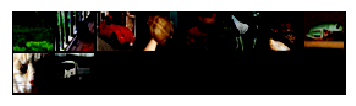

In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(images.shape)

### Check labelling

Useful in case of random shuffling of labels

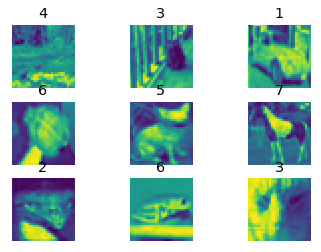

In [12]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i,0,:,:])
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i].item())

In [13]:
def get_stats(loader):   
    '''
    Compute training statistics (loss and accuracy) on loader data
    '''
    loss = 0.0
    correct = 0
    total = 0       
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        l = loss.to('cpu').item()/total
        acc = 100 * correct/total
        return [l,acc]

# Initialize network, optimizer and loss

In [14]:
from cifar10_archs import Net
model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [15]:
print(model)
print( summary(model, imgs_shape) )

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]            2416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]           48120
            Linear-6                   [-1, 84]           10164
            Linear-7                   [-1, 10]             850
Total params: tensor(62006)
T

In [55]:
 [ [ x.mean().item(), x.std().item()] for x in model.parameters() ]

[[0.0014867206336930394, 0.17646373808383942],
 [0.17059950530529022, 0.32505854964256287],
 [-8.250298560597003e-05, 0.09396062791347504],
 [-0.02701438032090664, 0.2814035415649414],
 [-0.0005066977464593947, 0.036390919238328934],
 [0.005678481422364712, 0.055882375687360764],
 [0.0015466570621356368, 0.0640023723244667],
 [0.021382730454206467, 0.11585549265146255],
 [-0.002481974894180894, 0.13839781284332275],
 [-0.007740011904388666, 0.2908135652542114]]

In [60]:
for x in model.parameters():
    print(type(x.mean().item()))

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


In [ ]:
train_stats = []
test_stats  = []
fractions   = []
params_stats= []
grad_stats  = []
grad2_stats = []
snr_stats   = []

for epoch in tqdm(range(epochs)):
    
    # init accumulators grad and grad2
    grad  = init_grad(model)
    grad2 = init_grad(model)  
    
    for i, data in enumerate(train_loader, 0):
                       
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)  
       
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        # compute the grad
        loss.backward()
                
        # accumulate grad and grad2
        grad  = acc_grad(grad,model)
        grad2 = acc_grad2(grad2,model)
        
        if (i + 1) % n == 0 : 
            
            # compute the snr 
            snr = compute_snr(grad, grad2, n)
            
            # temper the grad with the information on grad2
            fr = []
            
            with torch.no_grad():
                for p, g, s in zip(model.parameters(), grad, snr): 
                    
                    # average the grad            
                    g = g/n
                    
                    # this is the only line where the true gradient is touched
                    if MODIFIED_SGD:
                        p.grad = torch.where(s > 1, g, s * g)          
                    else:
                        p.grad = g
                        
                    fr.append(  ( s < 1).sum().item() / 
                             torch.prod(torch.tensor( s.size() ) ).item()  )       
            fractions.append(fr)
    
            # store statistics about params grad, grad2 and snr    
            params_stats.append([ [x.mean().item(), x.std().item()]  for x in model.parameters() ] )
            grad_stats.append(  [ [x.mean().item(), x.std().item()]  for x in grad] )
            grad2_stats.append( [ [x.mean().item(), x.std().item()]  for x in grad2] )
            snr_stats.append(   [ [x.mean().item(), x.std().item()]  for x in snr] )
        
            # this is called after the large batch of n mini-batches
            optimizer.step()
            
            # set to zero accumulators for grad and grad2
            grad  = init_grad(model)
            grad2 = init_grad(model)
            
                          
    # save model
    if SAVE:
        #model.save_state_dict(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        torch.save(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        
    # get statistics
    train_stats.append(get_stats(train_loader))
    test_stats.append(get_stats(test_loader))
        
    # print statistics
    print('Train loss : %g --- Train acc : %g %%' % ( train_stats[-1][0], train_stats[-1][1] )) 
    print('Test  loss : %g --- Test  acc : %g %%' % ( test_stats[-1][0],  test_stats[-1][1] ))         

  1%|          | 1/100 [00:13<21:52, 13.26s/it]

Train loss : 0.230186 --- Train acc : 10.284 %
Test  loss : 0.230177 --- Test  acc : 10.35 %


  2%|▏         | 2/100 [00:26<21:28, 13.15s/it]

Train loss : 0.229806 --- Train acc : 13.108 %
Test  loss : 0.2298 --- Test  acc : 13.2 %


  3%|▎         | 3/100 [00:39<21:09, 13.09s/it]

Train loss : 0.229196 --- Train acc : 15.126 %
Test  loss : 0.229201 --- Test  acc : 15.08 %


  4%|▍         | 4/100 [00:52<20:55, 13.07s/it]

Train loss : 0.227735 --- Train acc : 18.66 %
Test  loss : 0.227762 --- Test  acc : 18.58 %


  5%|▌         | 5/100 [01:05<20:40, 13.06s/it]

Train loss : 0.223179 --- Train acc : 20.96 %
Test  loss : 0.223231 --- Test  acc : 20.77 %


  6%|▌         | 6/100 [01:18<20:30, 13.09s/it]

Train loss : 0.212945 --- Train acc : 22.548 %
Test  loss : 0.213106 --- Test  acc : 22.99 %


  7%|▋         | 7/100 [01:32<20:26, 13.18s/it]

Train loss : 0.204238 --- Train acc : 27.422 %
Test  loss : 0.204306 --- Test  acc : 27.44 %


  8%|▊         | 8/100 [01:46<20:20, 13.27s/it]

Train loss : 0.199705 --- Train acc : 28.244 %
Test  loss : 0.199452 --- Test  acc : 28.37 %


  9%|▉         | 9/100 [02:00<20:14, 13.34s/it]

Train loss : 0.196273 --- Train acc : 29.49 %
Test  loss : 0.195905 --- Test  acc : 29.65 %


 10%|█         | 10/100 [02:13<20:00, 13.34s/it]

Train loss : 0.198497 --- Train acc : 28.382 %
Test  loss : 0.19762 --- Test  acc : 28.6 %


 11%|█         | 11/100 [02:27<19:51, 13.39s/it]

Train loss : 0.194944 --- Train acc : 29.83 %
Test  loss : 0.194309 --- Test  acc : 30.58 %


 12%|█▏        | 12/100 [02:40<19:39, 13.41s/it]

Train loss : 0.190118 --- Train acc : 30.412 %
Test  loss : 0.189567 --- Test  acc : 30.47 %


 13%|█▎        | 13/100 [02:54<19:26, 13.41s/it]

Train loss : 0.188591 --- Train acc : 32.2 %
Test  loss : 0.188374 --- Test  acc : 32.65 %


 14%|█▍        | 14/100 [03:07<19:14, 13.43s/it]

Train loss : 0.184969 --- Train acc : 31.704 %
Test  loss : 0.185027 --- Test  acc : 31.66 %


 15%|█▌        | 15/100 [03:21<19:00, 13.42s/it]

Train loss : 0.178593 --- Train acc : 35.402 %
Test  loss : 0.178155 --- Test  acc : 35.29 %


 16%|█▌        | 16/100 [03:34<18:46, 13.42s/it]

Train loss : 0.181568 --- Train acc : 34.558 %
Test  loss : 0.180662 --- Test  acc : 34.68 %


 17%|█▋        | 17/100 [03:47<18:32, 13.41s/it]

Train loss : 0.174555 --- Train acc : 36.6 %
Test  loss : 0.174511 --- Test  acc : 36.47 %


 18%|█▊        | 18/100 [04:01<18:20, 13.43s/it]

Train loss : 0.173408 --- Train acc : 37.458 %
Test  loss : 0.172803 --- Test  acc : 37.62 %


 19%|█▉        | 19/100 [04:15<18:10, 13.47s/it]

Train loss : 0.175182 --- Train acc : 36.302 %
Test  loss : 0.175484 --- Test  acc : 35.36 %


 20%|██        | 20/100 [04:29<17:57, 13.47s/it]

Train loss : 0.169257 --- Train acc : 38.704 %
Test  loss : 0.16899 --- Test  acc : 38.39 %


 21%|██        | 21/100 [04:43<17:45, 13.49s/it]

Train loss : 0.174518 --- Train acc : 37.75 %
Test  loss : 0.174746 --- Test  acc : 37.99 %


 22%|██▏       | 22/100 [04:57<17:34, 13.52s/it]

Train loss : 0.166873 --- Train acc : 39.278 %
Test  loss : 0.16668 --- Test  acc : 38.79 %


 23%|██▎       | 23/100 [05:11<17:23, 13.55s/it]

Train loss : 0.167942 --- Train acc : 37.764 %
Test  loss : 0.167822 --- Test  acc : 37.4 %


 24%|██▍       | 24/100 [05:25<17:09, 13.55s/it]

Train loss : 0.162179 --- Train acc : 41.5 %
Test  loss : 0.162643 --- Test  acc : 41 %


 25%|██▌       | 25/100 [05:39<16:57, 13.56s/it]

Train loss : 0.161389 --- Train acc : 42.292 %
Test  loss : 0.161426 --- Test  acc : 41.97 %


 26%|██▌       | 26/100 [05:52<16:44, 13.57s/it]

Train loss : 0.161308 --- Train acc : 41.568 %
Test  loss : 0.161644 --- Test  acc : 41.1 %


 27%|██▋       | 27/100 [06:06<16:31, 13.58s/it]

Train loss : 0.16026 --- Train acc : 42.372 %
Test  loss : 0.160613 --- Test  acc : 41.66 %


 28%|██▊       | 28/100 [06:20<16:18, 13.59s/it]

Train loss : 0.160489 --- Train acc : 42.87 %
Test  loss : 0.16052 --- Test  acc : 42.49 %


 29%|██▉       | 29/100 [06:34<16:05, 13.60s/it]

Train loss : 0.155115 --- Train acc : 44.438 %
Test  loss : 0.155797 --- Test  acc : 43.89 %


 30%|███       | 30/100 [06:48<15:52, 13.60s/it]

Train loss : 0.156178 --- Train acc : 43.202 %
Test  loss : 0.156577 --- Test  acc : 42.61 %


 31%|███       | 31/100 [07:02<15:40, 13.63s/it]

Train loss : 0.157815 --- Train acc : 42.9 %
Test  loss : 0.158425 --- Test  acc : 42.34 %


 32%|███▏      | 32/100 [07:16<15:26, 13.63s/it]

Train loss : 0.155189 --- Train acc : 43.964 %
Test  loss : 0.156192 --- Test  acc : 42.95 %


 33%|███▎      | 33/100 [07:30<15:15, 13.66s/it]

Train loss : 0.152672 --- Train acc : 45.36 %
Test  loss : 0.153259 --- Test  acc : 44.97 %


 34%|███▍      | 34/100 [07:44<15:02, 13.67s/it]

Train loss : 0.152712 --- Train acc : 44.79 %
Test  loss : 0.153187 --- Test  acc : 44.27 %


 35%|███▌      | 35/100 [07:59<14:50, 13.69s/it]

Train loss : 0.154791 --- Train acc : 45.238 %
Test  loss : 0.155918 --- Test  acc : 44.47 %


In [61]:
# save loss and accuracies in a dictionary
train_stats = np.asarray(train_stats)
test_stats  = np.asarray(test_stats)
fractions   = np.asarray(fractions)
params_stats= np.asarray(params_stats)
grad_stats  = np.asarray(grad_stats)
grad2_stats = np.asarray(grad2_stats)
snr_stats   = np.asarray(snr_stats)

tags = ['train_stats', 'test_stats', 'fractions', 'params_stats', 'grad_stats', 'grad2_stats', 'snr_stats' ]
vals = [train_stats, test_stats, fractions, params_stats, grad_stats, grad2_stats, snr_stats ]
training_data = dict(zip(tags, vals))
if SAVE:
    file = open( os.path.join( RES, 'training_data.pt') , 'wb' ) 
    pickle.dump(training_data,file)

NameError: name 'params_stats' is not defined

In [48]:
win = 30
nchecks = int( np.floor(len(train_loader.dataset)/(mb_size*n) ))
layer_names = [m[0] for idx,m in enumerate(model.named_modules()) ]
layer_names.remove('')
layer_names.remove('pool')
print(layer_names)

['conv1', 'conv2', 'fc1', 'fc2', 'fc3']


In [66]:
def plot_results(figname, train_stats, test_stats, fractions, grad_stats, grad2_stats):

    fig = plt.figure(figsize=(20,20))
    plt.subplot(4,4,1)
    plt.plot(train_stats[:,0],'-',label='training loss')
    plt.plot(test_stats[:,0],'-',label='test loss')
    plt.xlabel('epoch')
    plt.title('loss')
    plt.legend()

    plt.subplot(4,4,2)
    plt.plot(train_stats[:,1],'-',label='training accuracy')
    plt.plot(test_stats[:,1],'-',label='test accuracy')
    plt.xlabel('epoch')
    plt.title('accuracy')
    plt.legend()

    plt.subplot(4,4,3)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean(fractions[:,i*2], win ),label=layer_names[i] ) 
    plt.legend()
    plt.xlabel('epoch')
    plt.title('fraction of $\eta < 1$')

    plt.subplot(4,4,4)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad_stats[:,i*2,0], win ),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad mean')

    plt.subplot(4,4,5)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad_stats[:,i*2,1], win ),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad std')

    plt.subplot(4,4,6)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad2_stats[:,i*2,0], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad2 mean')

    plt.subplot(4,4,7)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad2_stats[:,i*2,1], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad2 std')

    plt.subplot(4,4,8)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( snr_stats[:,i*2,0], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('snr mean')

    plt.subplot(4,4,9)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( snr_stats[:,i*2,1], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('snr std')

    plt.savefig(os.path.join(FIG, figname))
    
    plt.show()


/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:27: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:34: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:41: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:48: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykerne

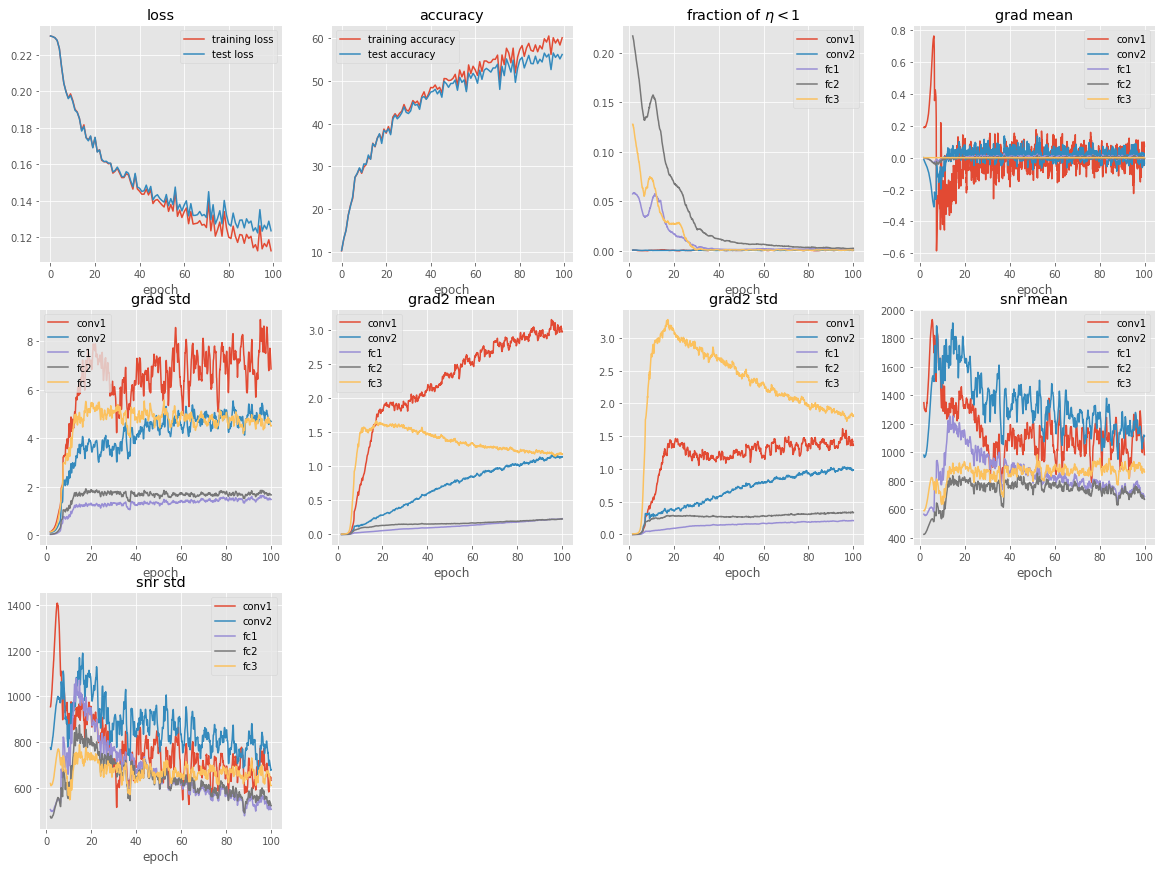

In [68]:
plot_results('prova', train_stats, test_stats, fractions, grad_stats, grad2_stats)


